<a href="https://colab.research.google.com/github/JanMeow/ML-cases/blob/main/09_PyTorchModelDeployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Import

In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [2]:
# Regular Import
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

#Try importing torchvision, install if it does not work
try:
  from torchinfo import summary
except:
  print('[INFO] torchvision not found..installing now')
  !pip install -q summary torchinfo
  from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
  from going_modular.going_modular import data_setup, engine
except:
  # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] torchvision not found..installing now
  Preparing metadata (setup.py) ... done
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3849, done.
remote: Counting objects: 100% (492/492), done.
remote: Compressing objects: 100% (279/279), done.
remote: Total 3849 (delta 259), reused 409 (delta 206), pack-reused 3357
Receiving objects: 100% (3849/3849), 649.90 MiB | 17.87 MiB/s, done.
Resolving deltas: 100% (2215/2215), done.
Updating files: 100% (248/248), done.


In [3]:
# Getting Data
def create_path(root_name: str,
                path_name: str,
                url: str,
                zip_file_name:str):
  import os
  import zipfile

  from pathlib import Path
  import requests


  # Setup Path for data file
  data_path = Path(root_name)
  image_path = data_path / path_name


  # if the image_folder doesnt exist, download it and prepare it
  if image_path.is_dir():
    print(f'{image_path} already exists !')
  else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents = True, exist_ok = True)

  # Download Pizza steak sushi data
  with open(data_path/ zip_file_name, 'wb') as f:
    request = requests.get(url)
    f.write(request.content)

  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / zip_file_name, "r") as zip_ref:
    zip_ref.extractall(image_path)

  # Remove the zip file
  os.remove(data_path/zip_file_name)
  return image_path


image_path = create_path (root_name = 'data', path_name = 'pizza_steak_sushi', url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip", zip_file_name ="pizza_steak_sushi_20_percent.zip" )

Did not find data/pizza_steak_sushi directory, creating one...


In [4]:
# Set up train and testing path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
def set_seed(seed:int = 42):
  torch.manual_seed(seed)
set_seed()

##1. Creating an EffNetB2 feature extractor
Feature Extractor = term for a transfer learning model that has its vase layers frozen and output layers (head layers) customerised for certain problem

https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2

In [7]:
def create_effNetb2_model(num_classes: int =3,
                          seed: int =42):
  torch.manual_seed(seed)
  #1. Set up pretrain EffNetB2 Weights
  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # Default meaning best available
  #2. Get EffNetB2 transforms
  transforms  = effnetb2_weights.transforms()
  #3. Setup Pretrained model instance
  effnetb2 = torchvision.models.efficientnet_b2(weights = effnetb2_weights)

  #4. Freeze the base layers in the model (Stop all layers from training)
  for param in effnetb2.parameters():
    param.requires_grad = False

  #5. Change the last layer of classifier into the number of classes we want
  effnetb2.classifier = nn.Sequential(
      nn.Dropout(p = 0.3, inplace = True),
      nn.Linear(in_features = 1408, out_features = num_classes, bias = True)
  )

  return effnetb2, transforms

In [8]:
effnetb2, effnetb2_transforms = create_effNetb2_model()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 81.6MB/s]


In [9]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
from torchinfo import summary

# Print summary of the model
summary(effnetb2,
        input_size = (1,3,224,224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width =20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 1. Create Train and Test DataLoader

In [11]:
import os

def create_dataloaders(
    train_dir:str,
    test_dir:str,
    transform: transforms.Compose,
    batch_size:int = 32,
    num_workers:int = os.cpu_count()
):
  from torchvision import datasets, transforms
  from torch.utils.data import DataLoader

  train_data = datasets.ImageFolder(root = train_dir, transform = transform)
  test_data = datasets.ImageFolder(root = test_dir, transform = transform)

  train_dataloader = DataLoader(train_data,
                                batch_size = batch_size,
                                shuffle = True,
                                num_workers = num_workers,
                                pin_memory = True)
  test_dataloader = DataLoader(test_data,
                               batch_size = batch_size,
                               shuffle = False,
                               num_workers = num_workers,
                               pin_memory = True)

  class_name = train_data.classes
  return train_dataloader, test_dataloader, class_name

In [12]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = create_dataloaders(train_dir = train_dir,
                                                                test_dir = test_dir,
                                                                transform = effnetb2_transforms,
                                                                batch_size = 32)

#2. Training EffNetB2 feature extractor

In [13]:
next(iter(train_dataloader_effnetb2))[0].shape

torch.Size([32, 3, 288, 288])

In [14]:
# Training function
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device)-> Tuple[float, float]:


  #1. Set model to train mode
  model.train()
  #2. Set up train loss and train accuracy values
  train_loss, train_acc = 0,0
  #3. Loop throigh data loader batches
  for batch, (X,y) in enumerate(dataloader):
    #3.0 Send data to target device
    X,y = X.to(device), y.to(device)
    #3.1 Make prediction
    y_pred = model(X)
    #3.2 Calculate an accumate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    #3.3 Optimizer zero grad
    optimizer.zero_grad()
    #3.4 Back Propagation
    loss.backward()
    #3.5 Optimizer Step
    optimizer.step()
    #Calculate and accumulate accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim =1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  #4. Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [15]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)
          # 1. Forward pass
          test_pred_logits = model(X)
          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()
          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [16]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:

  from tqdm.auto import tqdm
  model.to(device)
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }
  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [17]:
#Set Seed
set_seed()
#Loss function
loss_fn = torch.nn.CrossEntropyLoss()
#Optimizer
optimizer = torch.optim.Adam(params = effnetb2.parameters(),
                             lr = 1e-3)
# Train
effnetb2_results = train(model = effnetb2,
                         train_dataloader = train_dataloader_effnetb2,
                         test_dataloader = test_dataloader_effnetb2,
                         optimizer = optimizer,
                         loss_fn = loss_fn,
                         epochs = 20,
                         device = device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9432 | train_acc: 0.6188 | test_loss: 0.7431 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.6846 | train_acc: 0.8500 | test_loss: 0.5971 | test_acc: 0.8983
Epoch: 3 | train_loss: 0.5791 | train_acc: 0.8542 | test_loss: 0.5016 | test_acc: 0.9352
Epoch: 4 | train_loss: 0.4392 | train_acc: 0.9083 | test_loss: 0.4429 | test_acc: 0.9256
Epoch: 5 | train_loss: 0.4199 | train_acc: 0.9042 | test_loss: 0.4035 | test_acc: 0.9261
Epoch: 6 | train_loss: 0.4249 | train_acc: 0.8938 | test_loss: 0.3616 | test_acc: 0.9352
Epoch: 7 | train_loss: 0.4210 | train_acc: 0.8375 | test_loss: 0.3357 | test_acc: 0.9443
Epoch: 8 | train_loss: 0.3929 | train_acc: 0.8979 | test_loss: 0.3572 | test_acc: 0.9199
Epoch: 9 | train_loss: 0.3700 | train_acc: 0.8917 | test_loss: 0.3212 | test_acc: 0.9290
Epoch: 10 | train_loss: 0.3663 | train_acc: 0.8646 | test_loss: 0.2864 | test_acc: 0.9597
Epoch: 11 | train_loss: 0.3009 | train_acc: 0.9125 | test_loss: 0.2798 | test_acc: 0.9597
Epoch: 12 | train_l

##3 Inspecting EffNetB2 loss curves

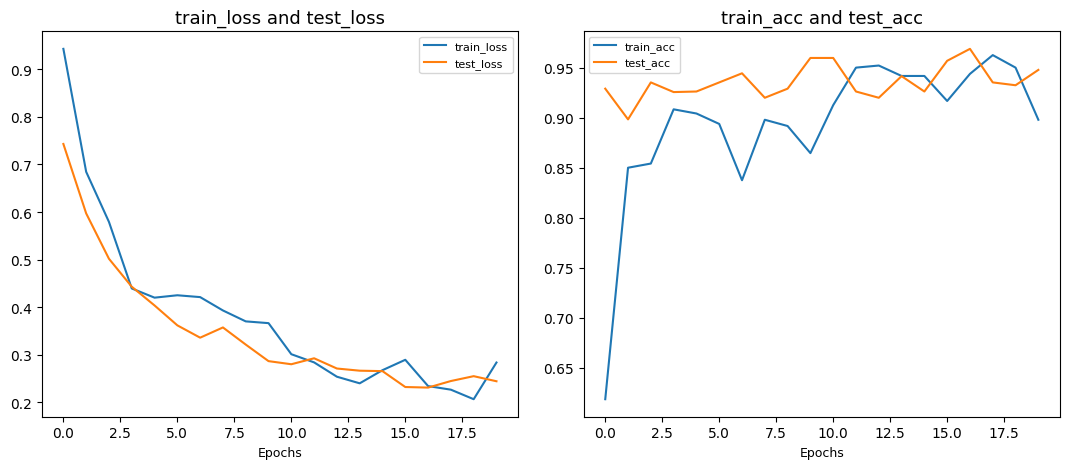

In [18]:
from typing import Dict

def plot_loss_curves(loss_dict: Dict):
  import matplotlib.pyplot as plt
  import numpy as np

  #Getting keys from dictionary for plotting
  key = list(loss_dict.keys())
  #Epochs count
  x = np.arange(len(loss_dict[key[0]]))
  # Make 2 subplots for loss and accuracy
  fig, ax = plt.subplots(1,2)

  for i in range(2):
     x= x
     y0= loss_dict[key[i]]
     y1= loss_dict[key[i+2]]

     ax[i].plot(x,y0,y1)
     ax[i].set_title(f'{key[i]} and {key[i+2]}', fontsize=13)
     ax[i].set_xlabel('Epochs', fontsize= 9)
     ax[i].legend([f'{key[i]}',f'{key[i+2]}'], fontsize = 8)
     fig.set_figwidth(11)
     fig.set_figheight(5)
  fig.tight_layout(pad = 1.8)

plot_loss_curves(effnetb2_results)

In [19]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

  from pathlib import Path
  import torch
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

save_model(model = effnetb2, target_dir = 'models', model_name = '09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth')

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


###3.1 Inspecting the size of our EffNetB2 feature Extractor for deployment perfomrance

In [20]:
from pathlib import Path

#Get the model size in bytes
pretrain_effnetb2_model_size = Path('/content/models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth').stat().st_size
print(f'pretrain_effnetb2_model_size in MB is {pretrain_effnetb2_model_size / (1024*1024):.2f}')

pretrain_effnetb2_model_size in MB is 29.86


###3.2 Collecting EffNet b2 Feature Extractor stats

In [21]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [80]:
#Create a dictionray witrh EffNetb2 statistics
effnetb2_results

effnetb2_stats = {'test_loss': effnetb2_results['test_loss'][-1],
                   'test_acc': effnetb2_results['test_acc'][-1],
                   'number_of_parameters':effnetb2_total_params,
                   'model_size(MB)': pretrain_effnetb2_model_size / (1024*1024)}
effnetb2_stats

{'test_loss': 0.24402595162391663,
 'test_acc': 0.9477272727272726,
 'number_of_parameters': 7705221,
 'model_size(MB)': 29.863232612609863}

#4. Creating an Vit feature extractor

In [23]:
def create_vitb16_model(num_classes: int =3,
                          seed: int =42):
  torch.manual_seed(seed)
  #1. Set up pretrain VitB16 Weights
  vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  #2. Get VitB16 transforms
  transforms = vit_weights.transforms()
  #3. Setup Pretrained model instance
  vitb16 = torchvision.models.vit_b_16(weights = vit_weights)

  #4. Freeze the base layers in the model (Stop all layers from training)
  for param in vitb16.parameters():
    param.requires_grad = False

  #5. Change the last layer of classifier into the number of classes we want
  vitb16.heads = nn.Sequential(
      nn.Linear(in_features = 768, out_features = num_classes, bias = True)
  )

  return vitb16, transforms

In [24]:
vitb16, vit_transforms = create_vitb16_model(num_classes =3, seed = 42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 183MB/s]


In [25]:
from torchinfo import summary

# Print summary of the model
summary(vitb16,
        input_size = (1,3,224,224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width =20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [26]:
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

##4.1 Training ViT Features Extractor

In [27]:
train_dataloader_vit, test_dataloader_vit, class_names = create_dataloaders(train_dir = train_dir,
                                                                            test_dir = test_dir,
                                                                            transform = vit_transforms,
                                                                            batch_size =32)

In [28]:
#Set Seed
set_seed()
#Loss function
loss_fn = torch.nn.CrossEntropyLoss()
#Optimizer
optimizer = torch.optim.Adam(params = vitb16.parameters(),
                             lr = 1e-3)
# Train
vitb16_results = train(model = vitb16,
                       train_dataloader = train_dataloader_vit,
                       test_dataloader = test_dataloader_vit,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 20,
                       device = device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6470 | train_acc: 0.8167 | test_loss: 0.2177 | test_acc: 0.9625
Epoch: 2 | train_loss: 0.2486 | train_acc: 0.9187 | test_loss: 0.1349 | test_acc: 0.9938
Epoch: 3 | train_loss: 0.1708 | train_acc: 0.9667 | test_loss: 0.1035 | test_acc: 0.9938
Epoch: 4 | train_loss: 0.1253 | train_acc: 0.9688 | test_loss: 0.0881 | test_acc: 0.9875
Epoch: 5 | train_loss: 0.1121 | train_acc: 0.9708 | test_loss: 0.0776 | test_acc: 0.9938
Epoch: 6 | train_loss: 0.1278 | train_acc: 0.9458 | test_loss: 0.0696 | test_acc: 0.9875
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9792 | test_loss: 0.0746 | test_acc: 0.9875
Epoch: 8 | train_loss: 0.0977 | train_acc: 0.9833 | test_loss: 0.0641 | test_acc: 0.9938
Epoch: 9 | train_loss: 0.0892 | train_acc: 0.9812 | test_loss: 0.0611 | test_acc: 0.9875
Epoch: 10 | train_loss: 0.0666 | train_acc: 0.9854 | test_loss: 0.0554 | test_acc: 0.9938
Epoch: 11 | train_loss: 0.0592 | train_acc: 0.9854 | test_loss: 0.0522 | test_acc: 0.9938
Epoch: 12 | train_l

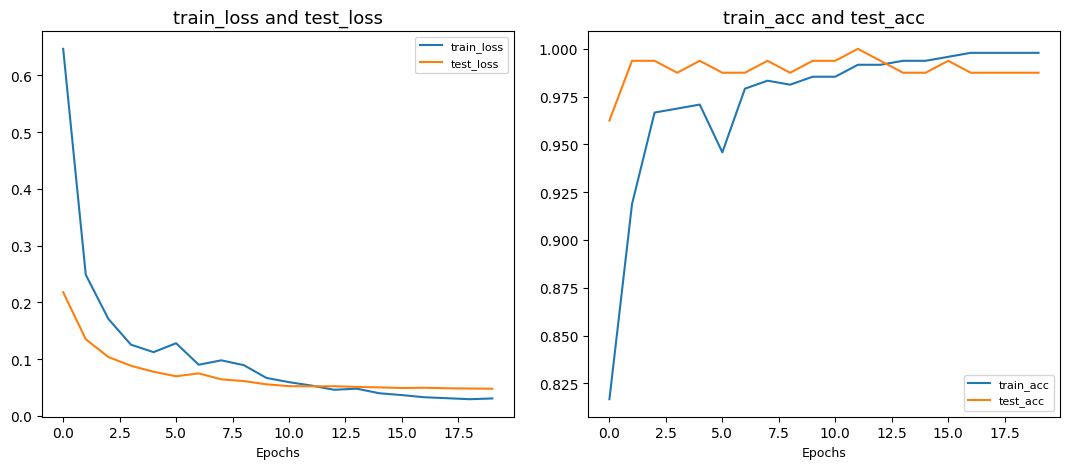

In [29]:
plot_loss_curves(vitb16_results)

In [30]:
save_model(model = vitb16,
           target_dir = 'models',
           model_name  = '09_pretrained_vitb16_feature_extractor_pizza_steak_sushi_20_percent.pth')

[INFO] Saving model to: models/09_pretrained_vitb16_feature_extractor_pizza_steak_sushi_20_percent.pth


In [31]:
# Count number of parameters in EffNetB2
vitb16_total_params = sum(torch.numel(param) for param in vitb16.parameters())
vitb16_total_params

85800963

In [32]:
from pathlib import Path

#Get the model size in bytes
pretrain_vitb16_model_size = Path('/content/models/09_pretrained_vitb16_feature_extractor_pizza_steak_sushi_20_percent.pth').stat().st_size
print(f'pretrain_vitb16_model_size in MB is {pretrain_effnetb2_model_size / (1024*1024):.2f}')

pretrain_vitb16_model_size in MB is 29.86


In [103]:
#Create a dictionray witrh EffNetb2 statistics
vitb16_results

vitb16_stats = {'test_loss': vitb16_results['test_loss'][-1],
                   'test_acc': vitb16_results['test_acc'][-1],
                   'number_of_parameters':vitb16_total_params,
                   'model_size(MB)': pretrain_vitb16_model_size / (1024*1024)}
vitb16_stats

{'test_loss': 0.04764887625351548,
 'test_acc': 0.9875,
 'number_of_parameters': 85800963,
 'model_size(MB)': 327.3708276748657}

##5. Making Predictions with our trained models and timing

In [35]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float,float]:
  import time
  t1 = time.time()
  model.to(device)
  #Put model in eval mode
  model.eval()
  #Setup test loss and test accuracy values
  test_loss, test_acc = 0,0
  #Inference mode
  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      #0.Send data to target device
      X,y = X.to(device), y.to(device)
      #1.Make prediction
      test_pred_logits = model(X)
      #2.Accumulate loss function
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()
      #3. Accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
  #Adjust metrics to get average loss
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  t2 = time.time()


  return test_loss, test_acc, t2-t1

In [36]:
#Set up loss function for vitb16
loss_fn = nn.CrossEntropyLoss()

test_loss_vitb16, test_acc_vitb16, time_vitb16 = test_step(model = vitb16,
                                                           dataloader = train_dataloader_vit,
                                                           loss_fn = loss_fn,
                                                           device = device)
test_loss_vitb16, test_acc_vitb16, time_vitb16

(0.02462225891261672, 1.0, 5.830383062362671)

In [37]:
#Set up loss function for effnetb2
loss_fn = nn.CrossEntropyLoss()

test_loss_effnetb2, test_acc_effnetb2, time_effnetb2 = test_step(model = effnetb2,
                                                                 dataloader = train_dataloader_effnetb2,
                                                                 loss_fn = loss_fn,
                                                                 device = device)
test_loss_effnetb2, test_acc_effnetb2, time_effnetb2

(0.15609676043192547, 0.98125, 2.8783175945281982)

In [38]:
# calculating average time for each image
from pathlib import Path
test_dir = Path('/content/data/pizza_steak_sushi/test')
length = 0
for item in test_dir.iterdir():
  length += len(list(item.iterdir()))
time_vitb16/length, time_effnetb2/length

(0.03886922041575114, 0.019188783963521323)

##4.2 Simulating and timing the entire inference siutation (From reading files to making prediction)

In [40]:
test_dir

PosixPath('/content/data/pizza_steak_sushi/test')

In [43]:
# Getting all the pictures for test
from pathlib import Path

test_data_paths = list(Path(test_dir).glob('*/*.jpg'))

test_data_paths[:5]

[PosixPath('/content/data/pizza_steak_sushi/test/sushi/2394442.jpg'),
 PosixPath('/content/data/pizza_steak_sushi/test/sushi/3886015.jpg'),
 PosixPath('/content/data/pizza_steak_sushi/test/sushi/124279.jpg'),
 PosixPath('/content/data/pizza_steak_sushi/test/sushi/1683426.jpg'),
 PosixPath('/content/data/pizza_steak_sushi/test/sushi/2378406.jpg')]

In [47]:
test_data_paths[0].parent.stem

'sushi'

In [54]:
import numpy as np
torch.argmax(torch.tensor([0,4,2])).item()

1

In [70]:
def pred_and_store(paths:list,
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device:str = 'cuda' if torch.cuda.is_available else 'cpu'):
  from timeit import default_timer as timer
  from PIL import Image
  from tqdm.auto import tqdm
  stats = []
  for path in tqdm(paths):
    stat_dict = {}
    ground_truth = path.parent.stem
    stat_dict['image_path'] = path
    stat_dict['class_name'] = ground_truth

    t1 = timer()
    image = Image.open(path)
    image = transform(image).unsqueeze(dim = 0).to(device)

    model.to(device)
    model.eval()
    with torch.inference_mode():
      y_logits = model(image)
      y_prob = torch.softmax(y_logits, dim = 1)
      y_pred = torch.argmax(y_prob, dim = 1).item()
      pred_class = class_names[y_pred]#python dictionay and pandas/ numpy needs the data to be stored on cpu

      stat_dict['pred_class'] = pred_class
      stat_dict['prediction_probability'] = round(y_prob.max().cpu().item(),4)
      stat_dict['prediction_class'] = y_pred

    t2 = timer()
    stat_dict['time_for_pred'] = round(t2-t1,4)

    stat_dict['correct'] = ground_truth == pred_class
    stats.append(stat_dict)
  return stats

In [84]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [85]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('/content/data/pizza_steak_sushi/test/sushi/2394442.jpg'),
  'class_name': 'sushi',
  'pred_class': 'sushi',
  'prediction_probability': 0.7929,
  'prediction_class': 2,
  'time_for_pred': 0.0965,
  'correct': True},
 {'image_path': PosixPath('/content/data/pizza_steak_sushi/test/sushi/3886015.jpg'),
  'class_name': 'sushi',
  'pred_class': 'sushi',
  'prediction_probability': 0.9508,
  'prediction_class': 2,
  'time_for_pred': 0.0815,
  'correct': True}]

In [86]:
#Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df

,image_path,class_name,pred_class,prediction_probability,prediction_class,time_for_pred,correct
0,/content/data/pizza_steak_sushi/test/sushi/239...,sushi,sushi,0.7929,2,0.0965,True
1,/content/data/pizza_steak_sushi/test/sushi/388...,sushi,sushi,0.9508,2,0.0815,True
2,/content/data/pizza_steak_sushi/test/sushi/124...,sushi,steak,0.4326,1,0.0741,False
3,/content/data/pizza_steak_sushi/test/sushi/168...,sushi,sushi,0.4733,2,0.0773,True
4,/content/data/pizza_steak_sushi/test/sushi/237...,sushi,sushi,0.4892,2,0.0736,True
...,...,...,...,...,...,...,...
145,/content/data/pizza_steak_sushi/test/pizza/225...,pizza,pizza,0.9392,0,0.0797,True
146,/content/data/pizza_steak_sushi/test/pizza/796...,pizza,pizza,0.9106,0,0.0701,True
147,/content/data/pizza_steak_sushi/test/pizza/337...,pizza,pizza,0.8391,0,0.0733,True
148,/content/data/pizza_steak_sushi/test/pizza/930...,pizza,pizza,0.9510,0,0.0712,True


In [87]:
effnetb2_test_pred_df.correct.value_counts()

True     143
False      7
Name: correct, dtype: int64

In [88]:
effnetb2_test_pred_df.time_for_pred.mean()

0.07832866666666667

In [89]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats ["time_per_pred_cpu"] = effnetb2_test_pred_df.time_for_pred.mean()
effnetb2_stats

{'test_loss': 0.24402595162391663,
 'test_acc': 0.9477272727272726,
 'number_of_parameters': 7705221,
 'model_size(MB)': 29.863232612609863,
 'time_per_pred_cpu': 0.07832866666666667}

In [90]:
# Make predictions across test dataset with EffNetB2
vitb16_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=vitb16,
                                          transform=vit_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [91]:
#Turn the test_pred_dicts into a DataFrame
import pandas as pd
vitb16_test_pred_df = pd.DataFrame(vitb16_test_pred_dicts)
vitb16_test_pred_df

,image_path,class_name,pred_class,prediction_probability,prediction_class,time_for_pred,correct
0,/content/data/pizza_steak_sushi/test/sushi/239...,sushi,sushi,0.9946,2,0.3479,True
1,/content/data/pizza_steak_sushi/test/sushi/388...,sushi,sushi,0.9522,2,0.3251,True
2,/content/data/pizza_steak_sushi/test/sushi/124...,sushi,sushi,0.9716,2,0.3318,True
3,/content/data/pizza_steak_sushi/test/sushi/168...,sushi,sushi,0.6860,2,0.3307,True
4,/content/data/pizza_steak_sushi/test/sushi/237...,sushi,sushi,0.9969,2,0.3426,True
...,...,...,...,...,...,...,...
145,/content/data/pizza_steak_sushi/test/pizza/225...,pizza,pizza,0.9993,0,0.5117,True
146,/content/data/pizza_steak_sushi/test/pizza/796...,pizza,pizza,0.9909,0,0.3064,True
147,/content/data/pizza_steak_sushi/test/pizza/337...,pizza,pizza,0.9992,0,0.3030,True
148,/content/data/pizza_steak_sushi/test/pizza/930...,pizza,pizza,0.9990,0,0.3156,True


In [92]:
vitb16_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [104]:
# Add vitb16 average prediction time to stats dictionary
vitb16_stats ["time_per_pred_cpu"] = vitb16_test_pred_df.time_for_pred.mean()
vitb16_stats

{'test_loss': 0.04764887625351548,
 'test_acc': 0.9875,
 'number_of_parameters': 85800963,
 'model_size(MB)': 327.3708276748657,
 'time_per_pred_cpu': 0.33874200000000004}

#5. Comparing model results, prediction times and size

In [105]:
# Creat comparison dataframe
import pandas as pd
df = pd.DataFrame([effnetb2_stats, vitb16_stats])
df['model'] = ['effnetb2', 'vit']

df['test_acc'] = round(df['test_acc']*100, 2)
df

,test_loss,test_acc,number_of_parameters,model_size(MB),time_per_pred_cpu,model
0,0.244026,94.77,7705221,29.863233,0.078329,effnetb2
1,0.047649,98.75,85800963,327.370828,0.338742,vit


In [106]:
# Compare ViT to EffNetB2 across different characteristics
comparision_df = pd.DataFrame(data=(df.set_index("model").loc["vit"] / df.set_index("model").loc["effnetb2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T
comparision_df

,test_loss,test_acc,number_of_parameters,model_size(MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.195262,1.041996,11.135432,10.962337,4.324624


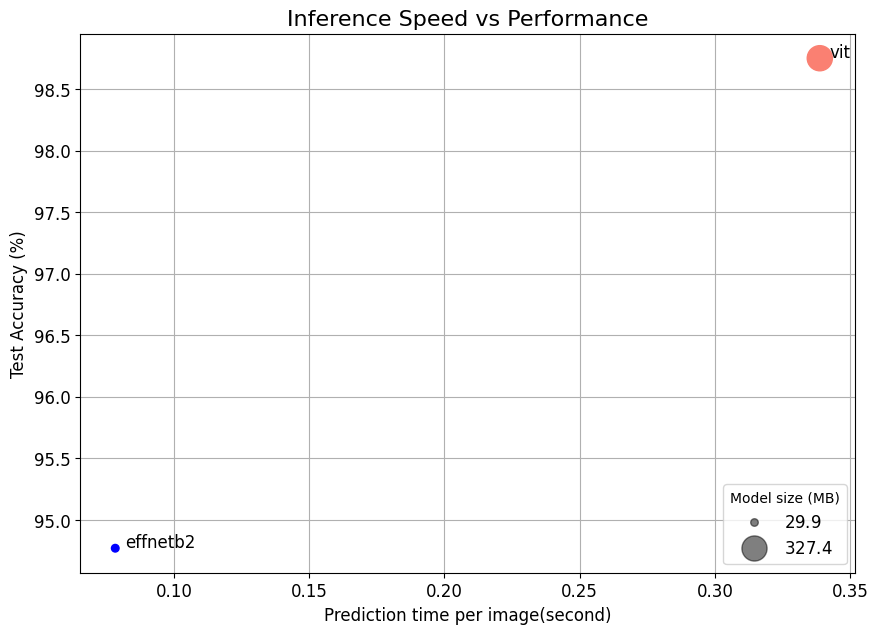

In [119]:
#1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,7))
scatter = ax.scatter(data = df,
                     x = 'time_per_pred_cpu',
                     y = 'test_acc',
                     c = ['blue', 'salmon'],
                     s ='model_size(MB)')

#2. Add Titlese and Labels
ax.set_title('Inference Speed vs Performance', fontsize = 16)
ax.set_xlabel('Prediction time per image(second)', fontsize = 12)
ax.set_ylabel('Test Accuracy (%)', fontsize = 12)
ax.tick_params(axis ='both', labelsize =12)
ax.grid (True)

# 3.Annotate the samples on the scatter plot
for index, row in df.iterrows():
  ax.annotate(text=row['model'],
              xy=(row['time_per_pred_cpu'] +0.0035, row['test_acc'] +0.008),
              size =12)
#4. Create a legend based on legend sizes
handles, labels = scatter.legend_elements(prop = 'sizes' , alpha = 0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc = 'lower right',
                              title = 'Model size (MB)',
                              fontsize = 12)
#Save the figure
plt.savefig('model-comparision.png')

##5. Creating a Gardio demo
Deploy EffnetB2 online

In [120]:
# Import/install Gardio

try:
  import gardio as gr
except:
  !pip -q install gradio
  import gradio as gr
print(f'Gardio version: {gr.__version__}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.8/288.8 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.8 MB/s eta 0:

###5.1 Gardio Overview

Gardio helps create machine learning demos
so other people can try and test them in the real world.
The overall premise of Gardio is to map inputs => function/model => outputs

In [122]:
# Put our model on the CPU
effnetb2 = effnetb2.to('cpu')

#Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [ ]:
def pred_and_store(paths:list,
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device:str = 'cuda' if torch.cuda.is_available else 'cpu'):
  from timeit import default_timer as timer
  from PIL import Image
  from tqdm.auto import tqdm
  stats = []
  for path in tqdm(paths):
    stat_dict = {}
    ground_truth = path.parent.stem
    stat_dict['image_path'] = path
    stat_dict['class_name'] = ground_truth

    t1 = timer()
    image = Image.open(path)
    image = transform(image).unsqueeze(dim = 0).to(device)

    model.to(device)
    model.eval()
    with torch.inference_mode():
      y_logits = model(image)
      y_prob = torch.softmax(y_logits, dim = 1)
      y_pred = torch.argmax(y_prob, dim = 1).item()
      pred_class = class_names[y_pred]#python dictionay and pandas/ numpy needs the data to be stored on cpu

      stat_dict['pred_class'] = pred_class
      stat_dict['prediction_probability'] = round(y_prob.max().cpu().item(),4)
      stat_dict['prediction_class'] = y_pred

    t2 = timer()
    stat_dict['time_for_pred'] = round(t2-t1,4)

    stat_dict['correct'] = ground_truth == pred_class
    stats.append(stat_dict)
  return stats

In [142]:
from typing import Tuple, Dict
def predict(img) ->Tuple[Dict,float]:
  #Start a timer
  from timeit import default_timer as timer
  t1 = timer()
  #Transform the input image for use with EffNetb2
  img = effnetb2_transforms(img).unsqueeze(0)
  #Put model into eval mode, make prediction
  effnetb2.eval()
  effnetb2.to('cpu')
  #Create a prediction label and prediction probability dictionary
  pred_dict = {}
  with torch.inference_mode():
    y_logits = effnetb2(img)
    y_prob = torch.softmax(y_logits, dim=1)
    y_preb = torch.argmax(y_prob, dim=1)

    for i,name in enumerate(class_names):
      pred_dict[name] = y_prob[0][i].item()
  #Calculate pred time
  t2 = timer()
  pred_time = round(t2-t1,4)
  #Return pred dict and pred time
  return pred_dict, pred_time

In [145]:
import random
from PIL import Image
from pathlib import Path

# Get a list of all test image file paths
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))

# Randomly select one image
idx = random.randint(0, len(test_data_paths))
random_image_path = test_data_paths[idx]

# Open the target image
image = Image.open(random_image_path)
image

# Predict on Target Image
pred_dict, pred_time = predict(img =image)
pred_dict, pred_time

({'pizza': 0.017368992790579796,
  'steak': 0.9736193418502808,
  'sushi': 0.009011550806462765},
 0.0749)

### 5.2 Creating a list of example images

In [146]:
#Create list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k =3)]
example_list

[['/content/data/pizza_steak_sushi/test/pizza/724290.jpg'],
 ['/content/data/pizza_steak_sushi/test/steak/1848936.jpg'],
 ['/content/data/pizza_steak_sushi/test/steak/108310.jpg']]

### 5.3 Building a Gardio Interface

Using `gr.Interface()` to go from:

input:image -> transform -> predict with EffnetB2 -> output: pred, prob

